In [3]:
#读取数据
import pandas as pd
import torch
import torch.nn as nn
import numpy as np


train_data = pd.read_csv("digit-recognizer-data/train.csv")

'''长教训了QAQ，下面这种写法是错误的
trainX=train_data.values[:][1:]
trainY=train_data.values[:][0]
'''
trainX=train_data.values[:,1:]
trainY=train_data.values[:,0]
#print(trainX.shape)
#print(trainY.shape)

test_data = pd.read_csv("digit-recognizer-data/test.csv")
testX=test_data.values[:,1:]
testY=test_data.values[:,0]

#print(train_data.columns)#输出表头信息

def printImage(id): #可以打印成图像输出
    print('数字为 : ' + str( trainY[id] ))
    for i in range(28):
        for j in range(28):
            print('#' if trainX[id][i*28+j] >0 else '.' ,end="")
        print()

#printImage(2333) #打印第2333个数字

In [4]:
class digitRecognizerModule(nn.Module):#神经网络模型
    def __init__(self):
        super().__init__()
        # 输入尺寸1×28×28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16,  # 输入通道1 输出通道16
                               kernel_size=(3, 3),  # 卷积核尺寸
                               stride=(1, 1),  # 卷积核每次移动多少个像素
                               padding=1)  # 原图片边缘加几个空白像素
        # conv1输出尺寸16×28×28
        self.pool1 = nn.MaxPool2d(kernel_size=2)  #第一次池化，输出尺寸16×14×14
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)  #第二次卷积，输出尺寸32×14×14
        self.pool2 = nn.MaxPool2d(2)  #第二次池化，输出尺寸32×7×7
        self.zhankai = nn.Flatten()#展平为张量，输出尺寸是一维1568(32*7*7)
        self.lin1 = nn.Linear(32 * 7 * 7, 16)#输出尺寸16
        self.jihuo = nn.ReLU()#激活函数
        self.lin2 = nn.Linear(16, 10)#输出尺寸10
    def forward(self,x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.zhankai(x)
        x = self.lin1(x)
        x = self.jihuo(x)
        x = self.lin2(x)
        return x

In [ ]:
#训练
net = digitRecognizerModule()
calcLoss = nn.CrossEntropyLoss() #loss用交叉熵来计算
optimizer = torch.optim.SGD(net.parameters(), lr=0.2) #optimizer是优化器，这里使用SGD随机梯度下降。lr是学习率

epochs = 10 #迭代次数
batch_size  = 128 #每批数据的大小为128，那么就有len(trainX)//barch批，每批数据的范围是[i * batch，(i+1) * batch)

# 记录训练过程
train_losses = [] #每个batch的损失
epoch_losses = [] #每个epoch的平均损失
train_accuracies = [] #每个epoch的准确率

for epoch in range(epochs):
    epoch_loss = 0.0
    correct = 0
    total = 0
    for i in range(len(trainX)//batch_size ):
        L = i * batch_size  
        R = (i+1) * batch_size 
        tmpX = trainX[L:R] / 255 #取出来这一批的数据并转为0~1的深度
        tmpX = tmpX.reshape(batch_size , 1, 28, 28) #转化形式，变成能输入网络的形式
        tmpX = torch.from_numpy(tmpX).float() #将numpy转为PyTorch张量

        tmpY = trainY[L:R] #Y同理
        tmpY = torch.from_numpy(tmpY)

        outputs = net(tmpX) #得到网络输出

        
        optimizer.zero_grad() #清空模型参数梯度
        loss = calcLoss(outputs, tmpY)
        loss.backward() #计算损失函数对模型参数的梯度
        optimizer.step() #更新模型参数


        #计算准确率
        _, predicted = torch.max(outputs.data, 1) #沿着张量的第1维计算最大值，返回最大值以及索引
        total += tmpY.size(0)
        correct += (predicted == tmpY).sum().item()
        #记录当前batch损失
        current_loss = loss.item()
        train_losses.append(current_loss)
        epoch_loss += current_loss
    
    #计算epoch指标
    epoch_losses.append(epoch_loss / (len(trainX) // batch_size))
    train_accuracies.append(100 * correct / total)
    
    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Loss: {epoch_loss / (len(trainX) // batch_size):.4f} | "
          f"Accuracy: {100 * correct / total:.2f}%")



Epoch [1/10] | Loss: 0.4431 | Accuracy: 85.47%
Epoch [2/10] | Loss: 0.1166 | Accuracy: 96.49%
Epoch [3/10] | Loss: 0.0727 | Accuracy: 97.73%
Epoch [4/10] | Loss: 0.0574 | Accuracy: 98.22%
Epoch [5/10] | Loss: 0.0479 | Accuracy: 98.53%
Epoch [6/10] | Loss: 0.0410 | Accuracy: 98.76%
Epoch [7/10] | Loss: 0.0350 | Accuracy: 98.98%
Epoch [8/10] | Loss: 0.0303 | Accuracy: 99.12%
Epoch [9/10] | Loss: 0.0260 | Accuracy: 99.25%
Epoch [10/10] | Loss: 0.0228 | Accuracy: 99.34%


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


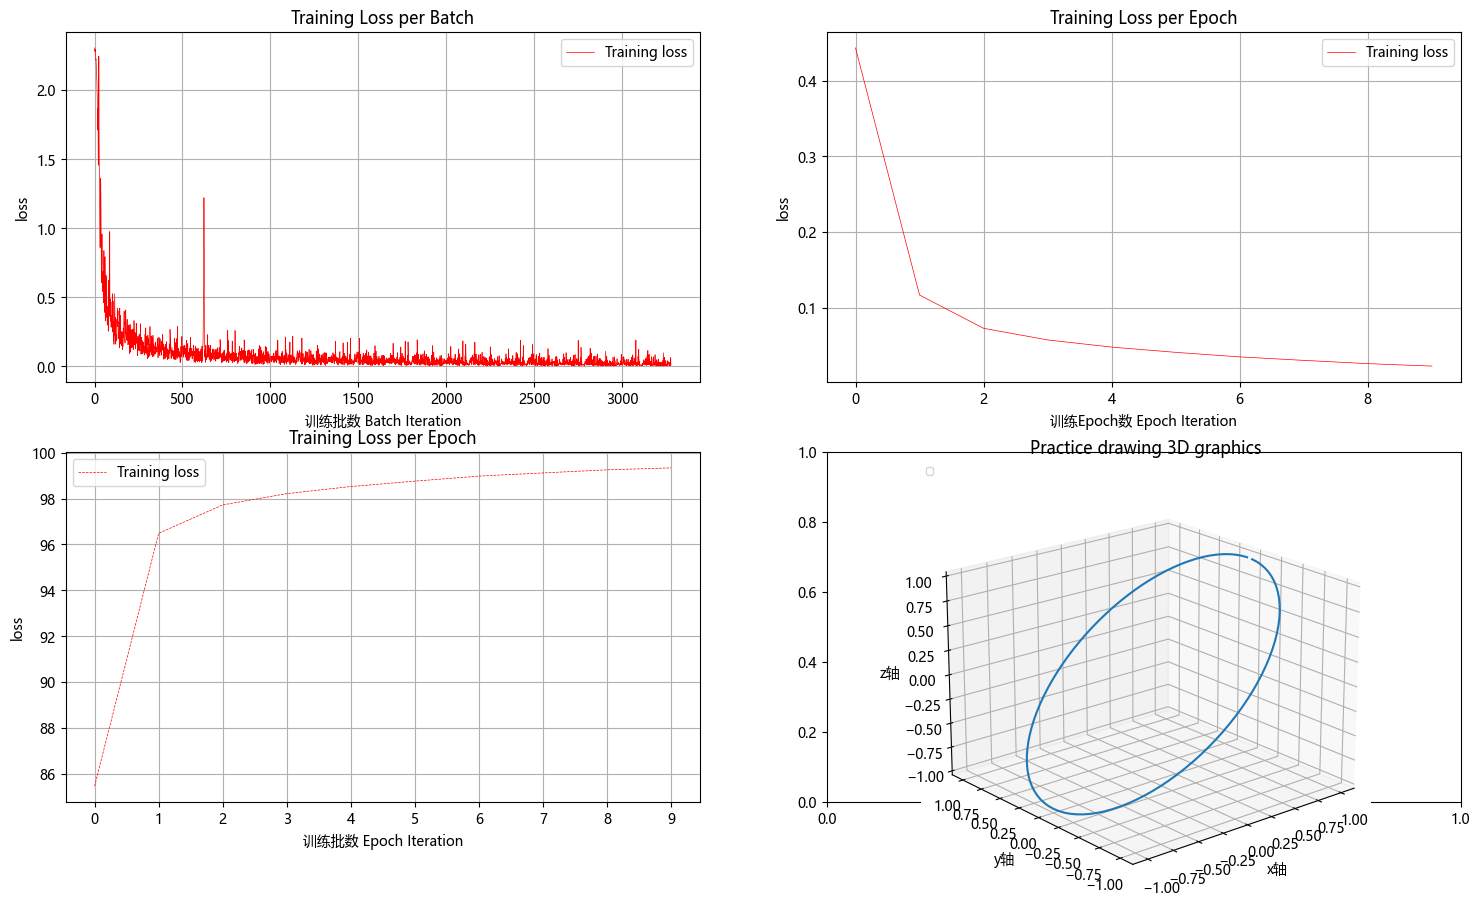

In [ ]:
#画图
from matplotlib import pyplot as plt

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  #这两句是防止画图里面的中文和负号变成乱码

#创建一个2*2的画图，figsize表示大小
fig,ax=plt.subplots(nrows=2, ncols=2, figsize=(18,10))

#画Batch loss
ax[0,0].plot(train_losses,label='Training loss',color='red',linewidth=0.5)
ax[0,0].set_title('Training Loss per Batch')
ax[0,0].set_xlabel('训练批数 Batch Iteration')
ax[0,0].set_ylabel('loss')
ax[0,0].legend(loc='upper right') #图例
ax[0,0].grid(True) #是否画网格

#画Epoch loss
ax[0,1].plot(epoch_losses,label='Training loss',color='red',linewidth=0.5)
ax[0,1].set_title('Training Loss per Epoch')
ax[0,1].set_xlabel('训练Epoch数 Epoch Iteration')
ax[0,1].set_ylabel('loss')
ax[0,1].legend(loc='upper right') #图例
ax[0,1].grid(True)

#画准确率
ax[1,0].plot(train_accuracies,label='Training loss',color='red',linewidth=0.5,linestyle='--')
ax[1,0].set_title('Training Loss per Epoch')
ax[1,0].set_xlabel('训练批数 Epoch Iteration')
ax[1,0].set_ylabel('loss')
ax[1,0].set_xticks(range(epochs)) #设置x轴刻度
#ax[1,0].set_ylim(0, 100)
ax[1,0].legend(loc='upper left') #图例
ax[1,0].grid(True)

#画了个3d图，画着玩的
ax_3d=fig.add_subplot(1,1,1,projection='3d') #这个可以用来画3d图，前三个参数分别是子图的行数、列数、在(行数*列数)中排第几个
ax_3d.set_position([0.5,0.0,0.45,0.45]) #四个参数决定在原图中的位置，分别是左、下、宽、高
ax_3d.set_title('Practice drawing 3D graphics')
ax_3d.set_xlabel('x轴')
ax_3d.set_ylabel('y轴')
ax_3d.set_zlabel('z轴')
ax_3d.legend(loc='upper left', fontsize=7, frameon=True)
ax_3d.grid(alpha=0.5, linestyle=':')
ax_3d.view_init(elev=20,azim=-130) #设置初始视角角度
npBegin=0
npEnd=2*np.pi
step=(npEnd-npBegin)/100
angles=np.arange(npBegin,npEnd,step)
ax_3d.plot3D(np.cos(angles),np.sin(angles),np.cos(angles))

plt.show()